In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error


In [5]:
df=pd.read_csv("faang_clean.csv")

In [6]:
df.head()

,Company,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Market Cap,...,Free Cash Flow,Operating Margin,Profit Margin,Quick Ratio,Price to Book Ratio,Enterprise Value,Total Debt,Beta (5Y),Annual Dividend Rate,Prev_Close
0,Apple,AAPL,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.973409,705555200,3575092084736,...,86158123008,0.29556,0.26441,0.798,53.66043,3569143513088,101304000512,1.239,1.0,1.151786
1,Apple,AAPL,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.044284,2227450400,3575092084736,...,86158123008,0.29556,0.26441,0.798,53.66043,3569143513088,101304000512,1.239,1.0,1.152679
2,Apple,AAPL,2005-01-10,1.246964,1.262500,1.212143,1.231429,1.039912,1725309600,3575092084736,...,86158123008,0.29556,0.26441,0.798,53.66043,3569143513088,101304000512,1.239,1.0,1.236607
3,Apple,AAPL,2005-01-11,1.218750,1.234821,1.145357,1.152857,0.973559,2611627200,3575092084736,...,86158123008,0.29556,0.26441,0.798,53.66043,3569143513088,101304000512,1.239,1.0,1.231429
4,Apple,AAPL,2005-01-12,1.168750,1.176786,1.130357,1.168929,0.987132,1919702400,3575092084736,...,86158123008,0.29556,0.26441,0.798,53.66043,3569143513088,101304000512,1.239,1.0,1.152857


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Company                   23040 non-null  object 
 1   Ticker                    23040 non-null  object 
 2   Date                      23040 non-null  object 
 3   Open                      23040 non-null  float64
 4   High                      23040 non-null  float64
 5   Low                       23040 non-null  float64
 6   Close                     23040 non-null  float64
 7   Adj Close                 23040 non-null  float64
 8   Volume                    23040 non-null  int64  
 9   Market Cap                23040 non-null  int64  
 10  PE Ratio                  23040 non-null  float64
 11  Beta                      23040 non-null  float64
 12  EPS                       23040 non-null  float64
 13  Forward PE                23040 non-null  float64
 14  Net In

In [8]:
df['Date']=pd.to_datetime(df['Date'])

In [9]:
aapl=df[df['Ticker']=='AAPL'].copy()

In [10]:
aapl=aapl.sort_values('Date')

In [11]:
## Set the date as Index

In [12]:
aapl.set_index('Date', inplace=True)

In [13]:
## Close price

In [14]:
aapl_close=aapl['Close']

In [15]:
## Plotting the time series

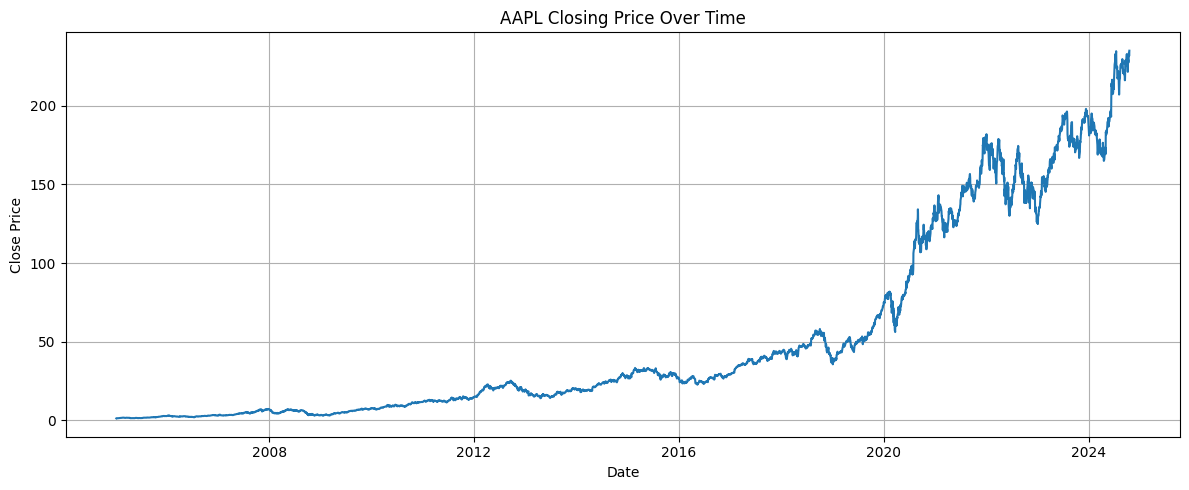

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(aapl_close)
plt.title("AAPL Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
###Step 2 -Stationarity

In [18]:
### Visual Insepction


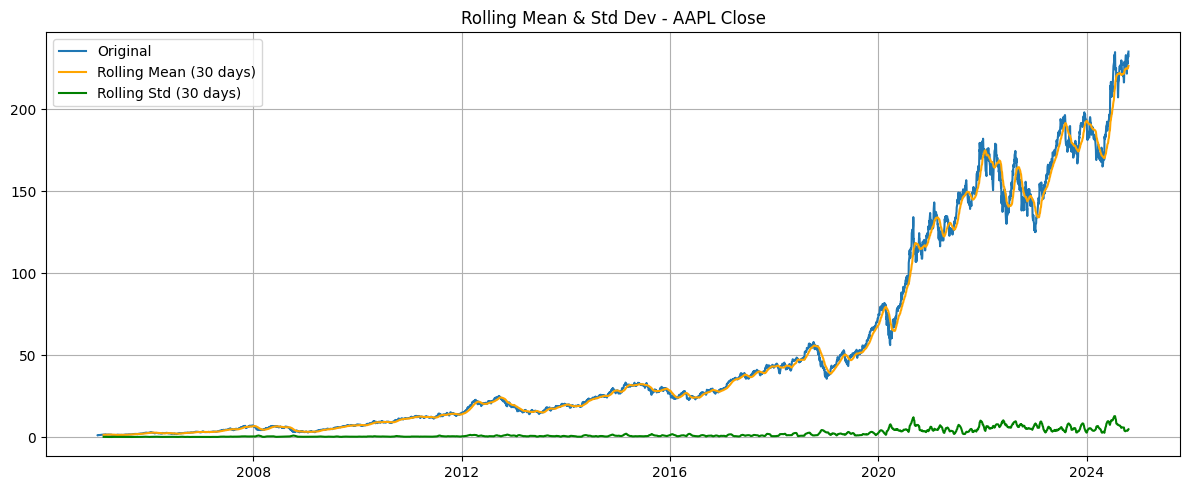

In [19]:
rolling_mean=aapl_close.rolling(window=30).mean()
rolling_std = aapl_close.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(aapl_close, label='Original')
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='orange')
plt.plot(rolling_std, label='Rolling Std (30 days)', color='green')
plt.title("Rolling Mean & Std Dev - AAPL Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
## AD fuller Test

In [22]:
result=adfuller(aapl_close)
print("ADF Statiscs",result[0])
print("p-value",result[1])

for key, value in result[4].items():
    print(f'Critical Value ({key}):{value}')

ADF Statiscs 1.9017084559870243
p-value 0.9985307626335856
Critical Value (1%):-3.431669090222372
Critical Value (5%):-2.8621228942049535
Critical Value (10%):-2.567080275469888


In [23]:
### First order of Differencing 

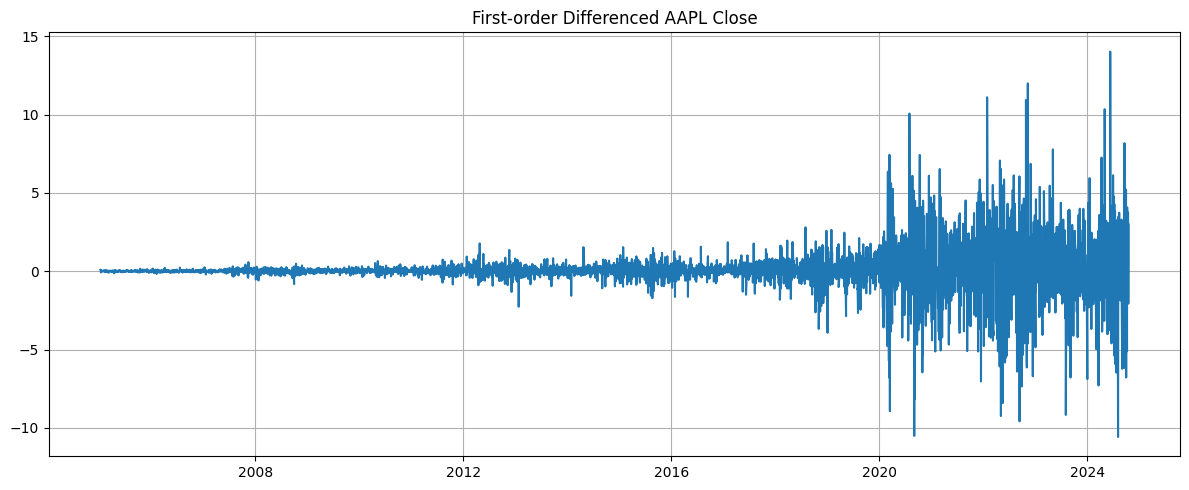

In [24]:
aapl_diff=aapl_close.diff().dropna()
plt.figure(figsize=(12, 5))
plt.plot(aapl_diff)
plt.title("First-order Differenced AAPL Close")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
result_d1=adfuller(aapl_diff)
print("ADF Statistic (Differenced):", result_d1[0])
print("p-value:", result_d1[1])
    

ADF Statistic (Differenced): -15.418262714750282
p-value: 3.058778799396844e-28


In [27]:
## Identifying the Arima terms

<Figure size 1200x500 with 0 Axes>

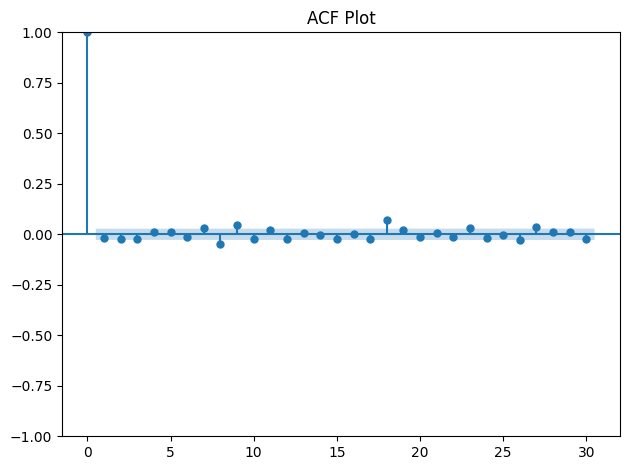

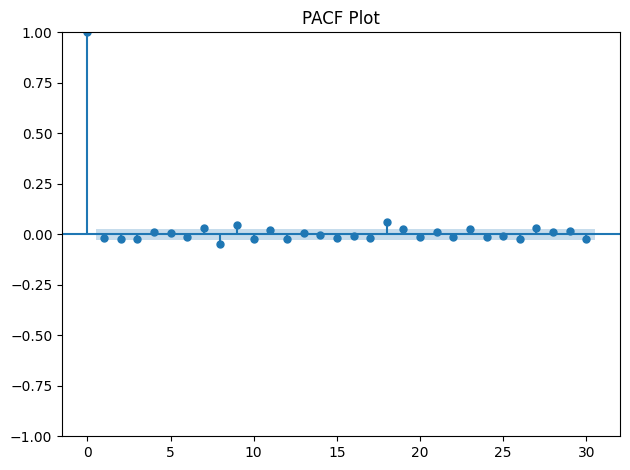

In [28]:
plt.figure(figsize=(12, 5))
plot_acf(aapl_diff,lags=30)
plt.title("ACF Plot")
plt.tight_layout()
plt.show()


plot_pacf(aapl_diff,lags=30,method='ywm')
plt.title("PACF Plot")
plt.tight_layout()
plt.show()

In [30]:
### Auto-Arima
from pmdarima import auto_arima
stepwise_model=auto_arima(
    aapl_close,
    start_p=0,max_p=3,
    start_1=0,max_q=3,
    d=1,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(stepwise_model.summary())

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17338.718, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17339.667, Time=0.19 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17339.878, Time=0.74 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17339.784, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17343.439, Time=0.17 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17339.701, Time=0.99 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=17338.200, Time=1.15 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17339.696, Time=3.61 sec


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=17342.786, Time=0.45 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 9.089 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4980
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -8664.100
Date:                Tue, 29 Jul 2025   AIC                          17338.200
Time:                        11:42:09   BIC                          17370.765
Sample:                             0   HQIC                         17349.616
                               - 4980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0470      0.018      2.554      0.011       0.011

In [31]:
### Modelling

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model=ARIMA(aapl_close,order=(0,1,3))

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
model_fit = model.fit()


In [35]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4980
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -8667.393
Date:                Tue, 29 Jul 2025   AIC                          17342.786
Time:                        11:44:48   BIC                          17368.838
Sample:                             0   HQIC                         17351.919
                               - 4980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0181      0.006     -2.835      0.005      -0.031      -0.006
ma.L2         -0.0224      0.007     -3.247      0.001      -0.036      -0.009
ma.L3         -0.0215      0.007     -3.008      0.0

In [36]:
### Forecasting Train/Test Split

In [37]:
# Define the split point: last 180 days as test
train = aapl_close[:-180]
test = aapl_close[-180:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 4800
Test size: 180


In [39]:
model_train=ARIMA(aapl_close,order=(0,1,3))
model_train_fit=model_train.fit()

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
print(model_train_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4980
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -8667.393
Date:                Tue, 29 Jul 2025   AIC                          17342.786
Time:                        11:52:58   BIC                          17368.838
Sample:                             0   HQIC                         17351.919
                               - 4980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0181      0.006     -2.835      0.005      -0.031      -0.006
ma.L2         -0.0224      0.007     -3.247      0.001      -0.036      -0.009
ma.L3         -0.0215      0.007     -3.008      0.0

In [38]:
## Forecast the Period

In [41]:
forecast=model_train_fit.forecast(steps=len(test))
forecast.index=test.index

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


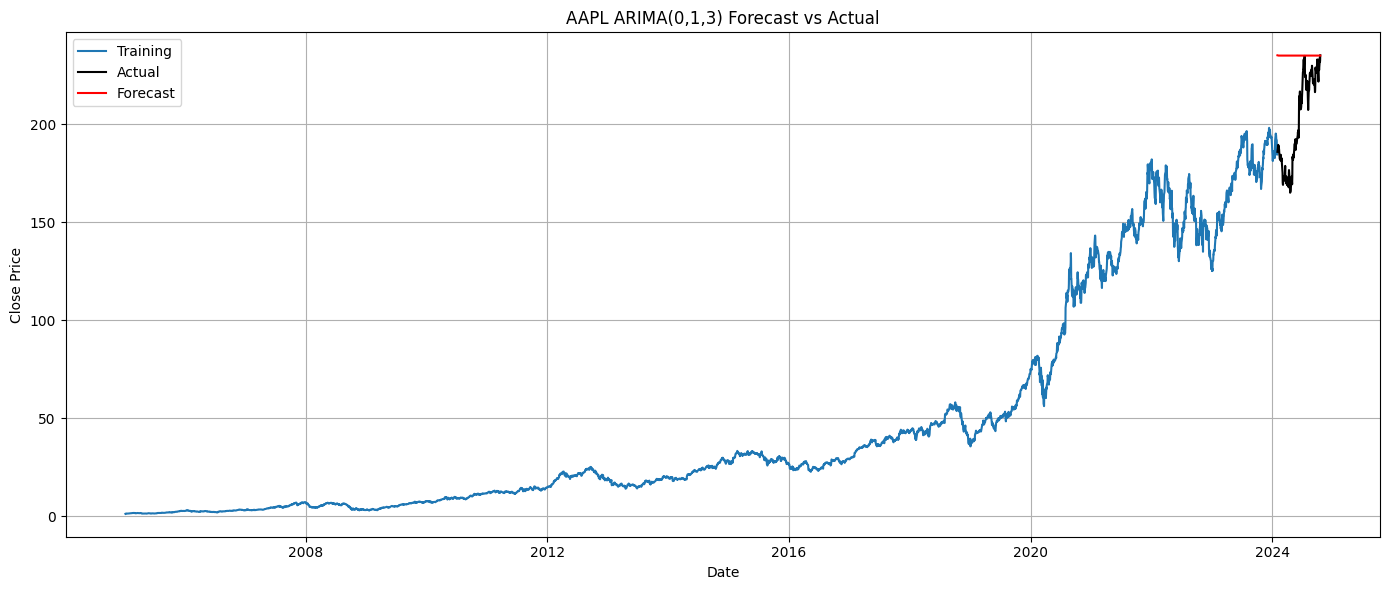

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title("AAPL ARIMA(0,1,3) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 33.83
RMSE: 40.93


In [45]:
### Hyperparameter Tuning(1,1,1)

In [92]:
# Fit ARIMA(1,1,1) on the same training set
model_alt = ARIMA(train, order=(1, 1, 1))
model_alt_fit = model_alt.fit()

# Summary
print(model_alt_fit.summary())


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4800
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7978.541
Date:                Tue, 29 Jul 2025   AIC                          15963.082
Time:                        12:54:02   BIC                          15982.511
Sample:                             0   HQIC                         15969.906
                               - 4800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4595      0.136      3.382      0.001       0.193       0.726
ma.L1         -0.4918      0.134     -3.669      0.000      -0.754      -0.229
sigma2         1.6277      0.011    142.202      0.0

In [93]:
# Forecast the same number of steps
forecast_alt = model_alt_fit.forecast(steps=len(test))

# Align forecast index with test
forecast_alt.index = test.index


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


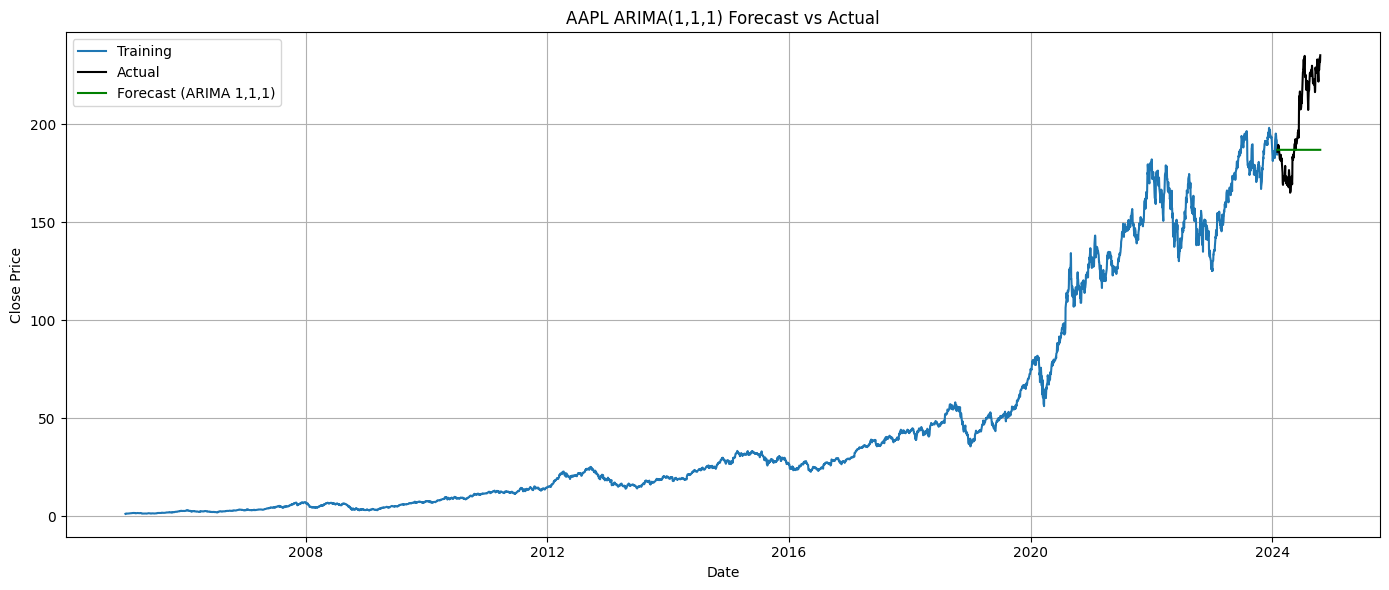

In [94]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(forecast_alt.index, forecast_alt, label='Forecast (ARIMA 1,1,1)', color='green')
plt.title("AAPL ARIMA(1,1,1) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [95]:
mae_alt = mean_absolute_error(test, forecast_alt)
rmse_alt = np.sqrt(mean_squared_error(test, forecast_alt))

print(f"MAE (1,1,1): {mae_alt:.2f}")
print(f"RMSE (1,1,1): {rmse_alt:.2f}")


MAE (1,1,1): 22.83
RMSE (1,1,1): 27.10


In [50]:
### Residual Analysis

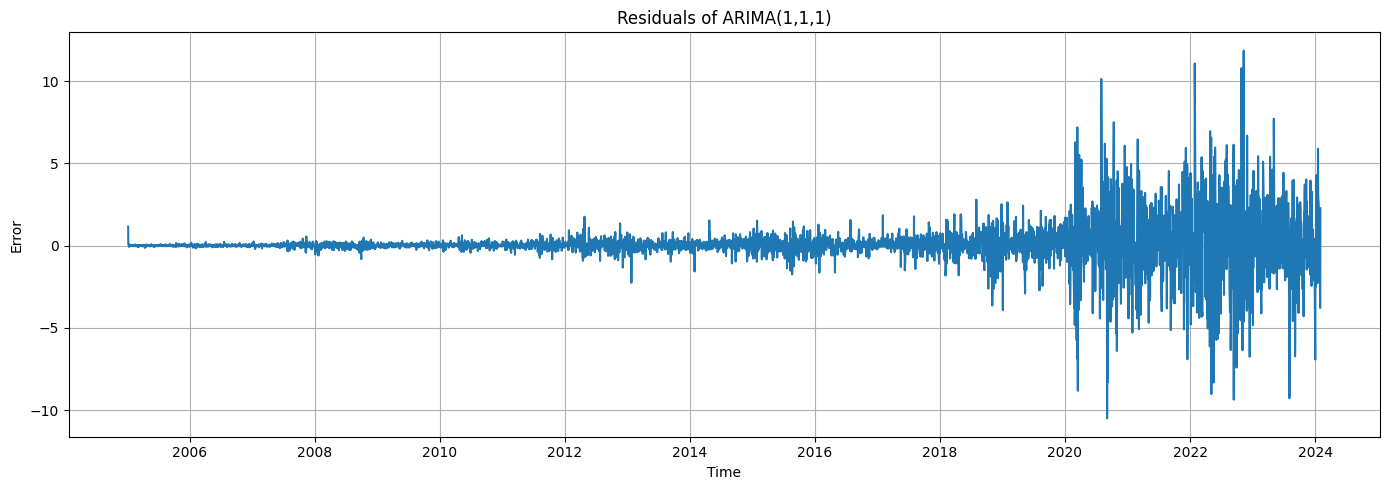

In [96]:
# Get residuals
residuals = model_alt_fit.resid

# Plot residuals
plt.figure(figsize=(14, 5))
plt.plot(residuals)
plt.title("Residuals of ARIMA(1,1,1)")
plt.xlabel("Time")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()


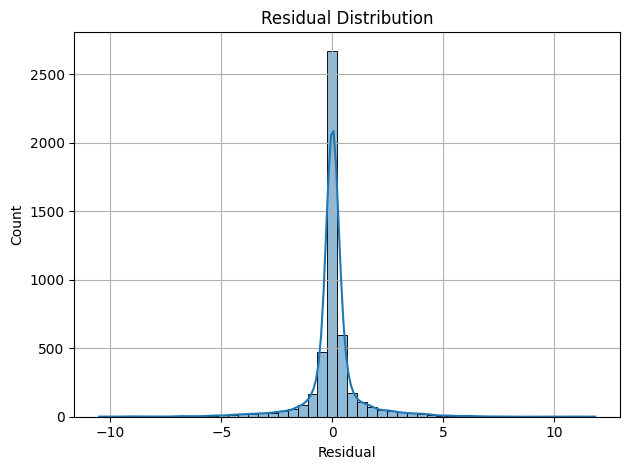

In [97]:
sns.histplot(residuals, kde=True, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


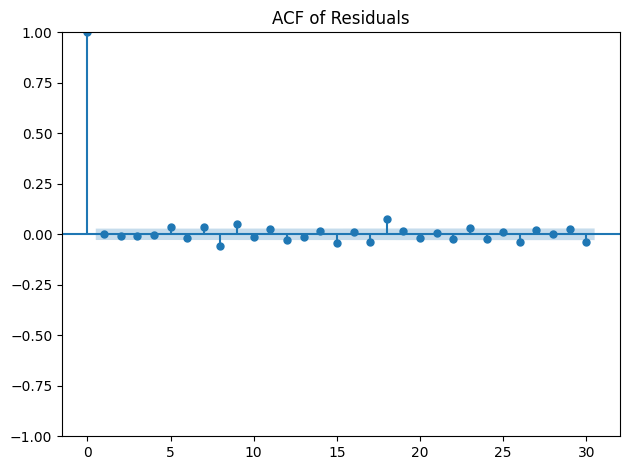

In [98]:
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.tight_layout()
plt.show()


In [54]:
##Ljung Box Test

In [99]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)


      lb_stat  lb_pvalue
10  44.079903   0.000003


In [56]:
### Its not generalizing properly

# Sarima Model

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,30))
model_sarima_fit = model_sarima.fit()


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [78]:
print(model_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 4800
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 30)   Log Likelihood               -7974.648
Date:                            Tue, 29 Jul 2025   AIC                          15959.296
Time:                                    12:15:04   BIC                          15991.677
Sample:                                         0   HQIC                         15970.668
                                           - 4800                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4673      0.133      3.526      0.000       0.208       0.727
ma.L1         -0.5000      0.131   

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


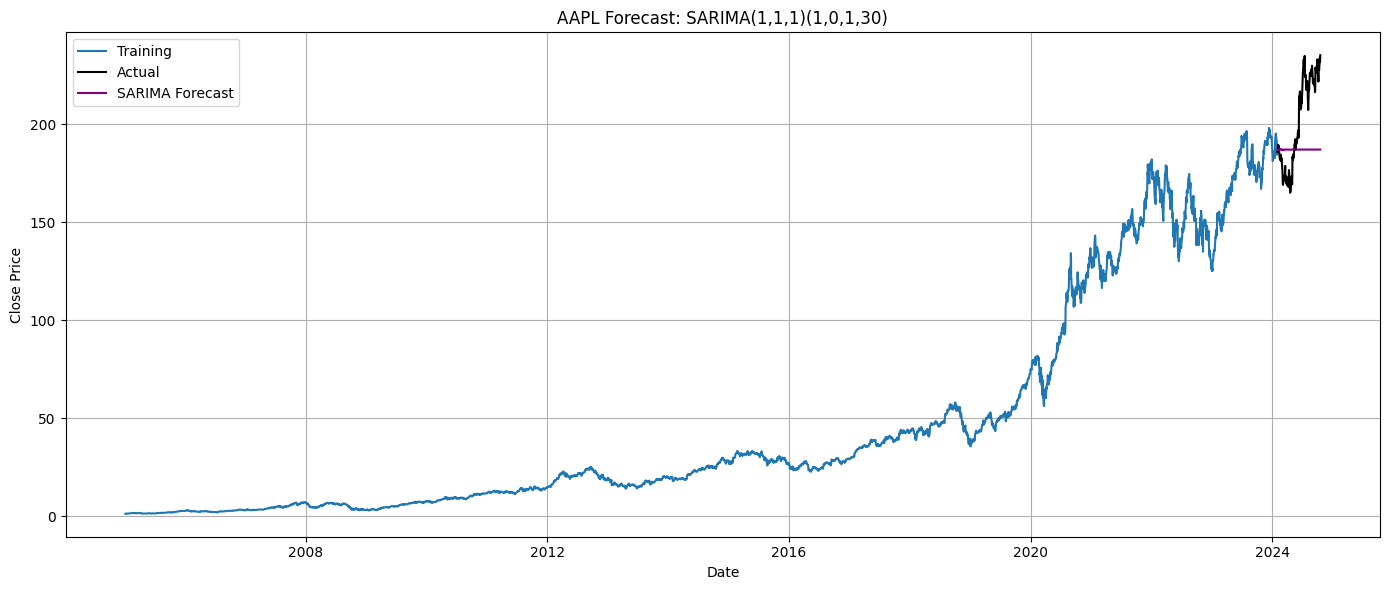

In [82]:
# Forecast into test set
forecast_sarima = model_sarima_fit.forecast(steps=len(test))
forecast_sarima.index = test.index

# Plot
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', color='purple')
plt.title("AAPL Forecast: SARIMA(1,1,1)(1,0,1,30)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")


SARIMA MAE: 22.79
SARIMA RMSE: 27.02


In [75]:
##Ljung Box Test on SARIMA RESIDUALS

In [83]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get residuals
sarima_resid = model_sarima_fit.resid

# Perform Ljung-Box test for multiple lags
ljung_sarima = acorr_ljungbox(sarima_resid, lags=[10, 20, 30], return_df=True)
print(ljung_sarima)


       lb_stat     lb_pvalue
10   43.275348  4.439759e-06
20   96.912186  4.477450e-12
30  119.645598  1.169669e-12
